#### 도로 영역을 찾자! - 세그멘테이션 모델 만들기

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *



Albumentation <br>
Compose() : 다양한 augmentation 기법을 확률적으로 적용, imgaug의 Sometimes()와 유사

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

aumentation 테스트

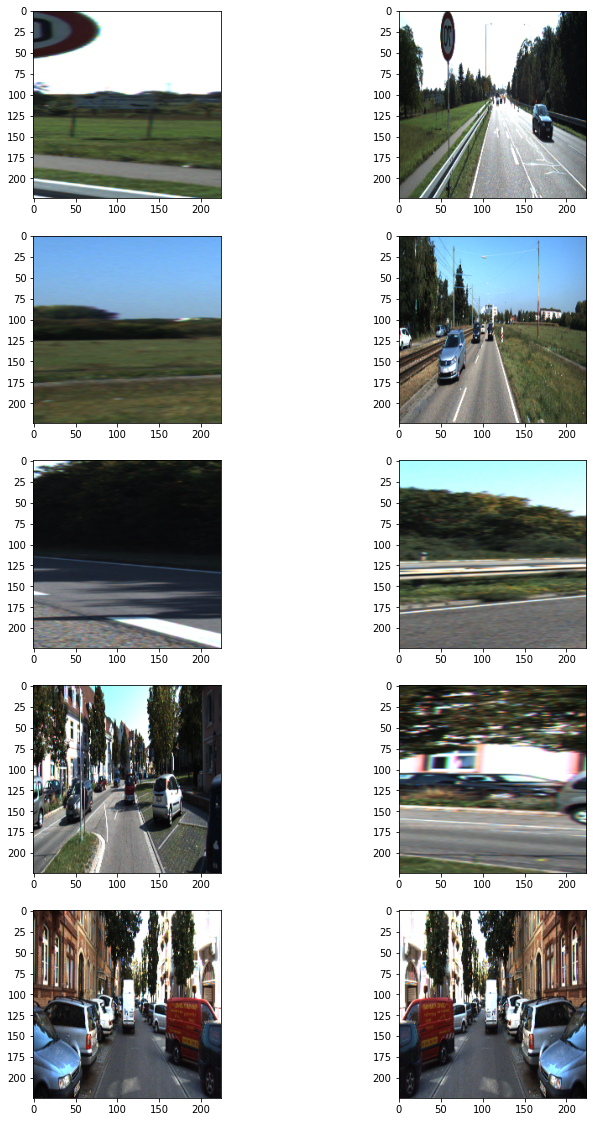

In [3]:
dir_path = './data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

데이터셋 구성 : tf.keras.utils.Sequence 상속 generator 형태로 데이터 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

U-Net기본 모델 

In [7]:
def build_model_base(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3,up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2,up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [8]:
unet_base_model = build_model_base()
unet_base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 220, 220, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
model_path_base = os.getenv('HOME')+'/aiffel/semantic_segmentation/model/seg_model_unet_base.h5'

unet_base_model = build_model_base()
unet_base_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_base = unet_base_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_base_model.save(model_path_base) 

Epoch 1/100
43/43 [==============================] - 15s 139ms/step - loss: 0.5925 - val_loss: 0.6765
Epoch 2/100
43/43 [==============================] - 6s 131ms/step - loss: 0.3623 - val_loss: 0.5237
Epoch 3/100
43/43 [==============================] - 6s 133ms/step - loss: 0.2673 - val_loss: 0.4797
Epoch 4/100
43/43 [==============================] - 6s 133ms/step - loss: 0.2356 - val_loss: 0.6299
Epoch 5/100
43/43 [==============================] - 6s 135ms/step - loss: 0.2167 - val_loss: 0.6944
Epoch 6/100
43/43 [==============================] - 6s 135ms/step - loss: 0.2064 - val_loss: 0.6985
Epoch 7/100
43/43 [==============================] - 6s 136ms/step - loss: 0.1990 - val_loss: 0.6791
Epoch 8/100
43/43 [==============================] - 6s 135ms/step - loss: 0.1961 - val_loss: 0.6798
Epoch 9/100
43/43 [==============================] - 6s 133ms/step - loss: 0.1880 - val_loss: 0.6743
Epoch 10/100
43/43 [==============================] - 6s 133ms/step - loss: 0.1851 - val_l

Predefined model 사용

In [10]:
unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
unet_model_base = tf.keras.models.load_model(unet_model_path)

U-Net++ 모델

In [11]:
def build_model_v1(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path(Backbone)
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    # Re-designed skip pathways
    # conv1_1, conv2_1, conv3_1
    up_conv2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    # conv1_2, conv2_2
    up_conv2_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    # conv1_3
    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [12]:
unet_model_v1 = build_model_v1(input_shape=(224, 224, 3))
unet_model_v1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 222, 222, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 220, 220, 64) 36928       conv2d_46[0][0]                  
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 220, 220, 64) 256         conv2d_47[0][0]                  
____________________________________________________________________________________________

In [13]:
unet_model_v1_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_v1.h5'

unet_model_v1 = build_model_v1()

unet_model_v1.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_v1 = unet_model_v1.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     )

Epoch 1/100
43/43 [==============================] - 29s 425ms/step - loss: 0.2557 - val_loss: 0.5106
Epoch 2/100
43/43 [==============================] - 18s 414ms/step - loss: 0.1748 - val_loss: 0.5225
Epoch 3/100
43/43 [==============================] - 18s 410ms/step - loss: 0.1708 - val_loss: 0.7253
Epoch 4/100
43/43 [==============================] - 18s 409ms/step - loss: 0.1672 - val_loss: 0.7492
Epoch 5/100
43/43 [==============================] - 18s 410ms/step - loss: 0.1676 - val_loss: 0.7796
Epoch 6/100
43/43 [==============================] - 18s 411ms/step - loss: 0.1663 - val_loss: 0.7558
Epoch 7/100
43/43 [==============================] - 18s 410ms/step - loss: 0.1619 - val_loss: 0.7235
Epoch 8/100
43/43 [==============================] - 18s 410ms/step - loss: 0.1596 - val_loss: 0.7053
Epoch 9/100
43/43 [==============================] - 18s 410ms/step - loss: 0.1599 - val_loss: 0.2798
Epoch 10/100
43/43 [==============================] - 18s 409ms/step - loss: 0.161

In [14]:
unet_model_v1.save(unet_model_v1_path)  # 학습한 모델 저장

unet_model_v1 = tf.keras.models.load_model(unet_model_v1_path)

In [15]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return

U-Net Base Result

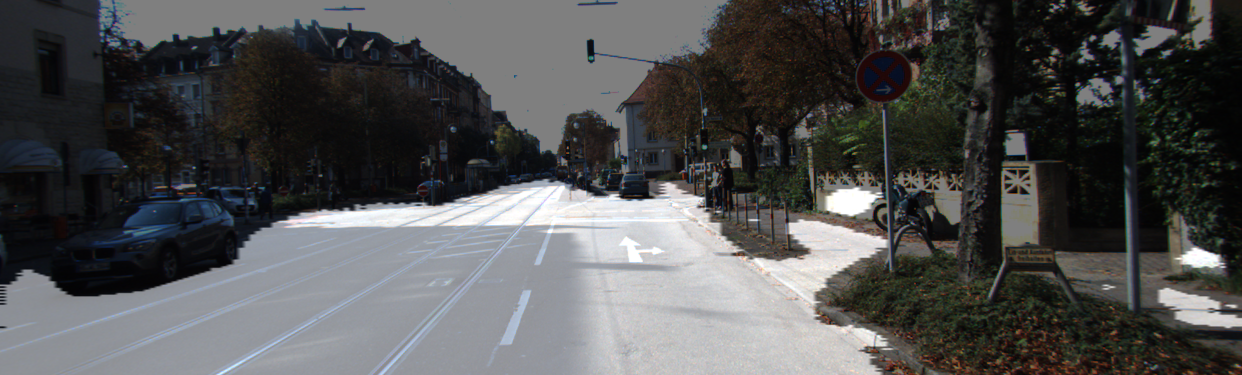

IoU : 0.882177


In [17]:
i = 1   # i값을 바꾸면 테스트용 파일이 달라집니다. 

output, prediction, target = get_output(
     unet_model_base, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

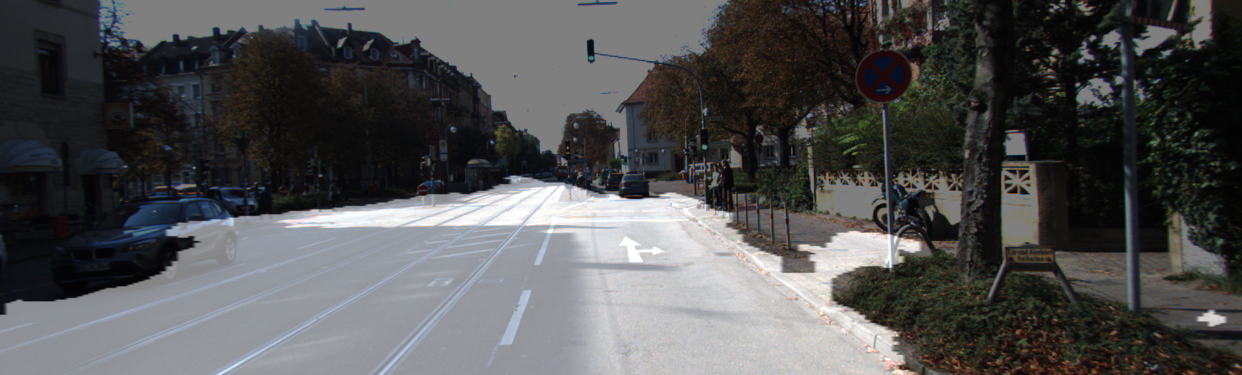

IoU : 0.861065


In [18]:
i = 1   # i값을 바꾸면 테스트용 파일이 달라집니다. 

output, prediction, target = get_output(
     unet_model_v1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [19]:
unet_model_base.history

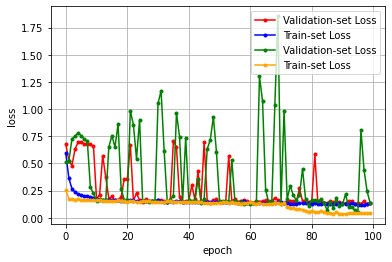

In [22]:
y_vloss = history_base.history['val_loss']
y_loss = history_base.history['loss']
y_vloss_v1 = history_v1.history['val_loss']
y_loss_v1 = history_v1.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss_v1, marker='.', c='green', label="Validation-set Loss")
plt.plot(x_len, y_loss_v1, marker='.', c='orange', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 회고

- 개선 전/후 IoU 비교<br>
  개선 전 : 0.882177<br>
  개선 후 : 0.861065<br> 
- 개선 후가 오히려 더 낮은 IoU를 보임 EPOCH을 더 늘리거나 데이터 보정이 이뤄지는 경우 정상적인 상황에서는 개선 후가 더 높다고 판단함<br>
- Train과 Validation의 비율이 매우 높고 불안정하게 움직이고 있어서 데이터부문 및 모델 부문에 추가적인 수정을 통하여 확인 필요
- Train에 비해 Validation의 격차가 많이 심하여  augmentation시 비정상적인 데이터에 대한 사전 추가적인 보정작업이 필요
- EPOCH을 늘려도 동일한 현상이 반복됨을 확인